In [1]:
import zarr
import glob
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from rich import print
from pathlib import Path
from omegaconf import OmegaConf
from dataclasses import dataclass, fields
from matplotlib.colors import LinearSegmentedColormap
from alive_progress import alive_it
from sortedcontainers import SortedList
from scipy import stats
from walrus_workshop.utils import get_key_value_from_string
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.model import load_sae
from walrus_workshop import metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [2]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

In [3]:
def plot_metrics(trajectory, steps, cfg=cfg):
    num_steps = len(steps)
    enstrophy = np.array([])
    dEdt = np.array([])
    deformation = np.array([])
    okubo_weiss = np.array([])
    ss = np.array([])
    t = np.array([])
    for step_index in range(num_steps):
        step = steps[step_index]
        simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
        enstrophy_ = []
        for i in range(simulation_chunk.shape[0]):
            enstrophy_.append(metrics.compute_enstrophy(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3])[0])
        dEdt = np.concatenate([dEdt, list(np.diff(enstrophy_))])
        enstrophy = np.concatenate([enstrophy, enstrophy_[:-1]])
        for i in range(simulation_chunk.shape[0]-1):
            deformation = np.concatenate([deformation, [np.mean(metrics.compute_deformation(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3])[0])]])
            okubo_weiss = np.concatenate([okubo_weiss, [np.mean(metrics.compute_okubo_weiss(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3])[0])]])
            ss = np.concatenate([ss, [np.mean(metrics.compute_okubo_weiss(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3])[2])]])
        t = np.concatenate([t, [s for s in range(step, step+cfg.walrus.n_steps_input)]])

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    axes[0, 0].plot(t[np.argsort(t)], enstrophy[np.argsort(t)], '-x')
    axes[0, 0].set_title('Enstrophy')
    axes[0, 1].plot(t[np.argsort(t)], dEdt[np.argsort(t)], '-')
    axes[0, 1].axhline(0, color='k', linewidth=0.5)
    axes[0, 1].set_title('Enstropy derivative')
    axes[0, 2].plot(t[np.argsort(t)], deformation[np.argsort(t)], '-')
    axes[0, 2].set_title('Deformation')
    axes[1, 0].plot(t[np.argsort(t)], okubo_weiss[np.argsort(t)], '-')
    axes[1, 0].set_title('Okubo-Weiss')
    axes[1, 0].axhline(0, color='k', linewidth=0.5)
    axes[1, 1].plot(t[np.argsort(t)], ss[np.argsort(t)], '-')
    axes[1, 1].set_title('Shear strain')
    axes[1, 1].axhline(0, color='k', linewidth=0.5)
    
    fig.tight_layout()
    plt.show()    

In [4]:
@dataclass
class DataChunk:
    t: np.ndarray
    enstrophy: np.ndarray
    dEdt: np.ndarray
    features: np.ndarray

def get_data_chunk(trajectory, steps, act_files, cfg=cfg, sae_model=sae_model):
    num_steps = len(steps)
    enstrophy = np.array([])
    dEdt = np.array([])
    t = np.array([])
    features = np.array([])
    for step_index in alive_it(range(num_steps), force_tty=True):
        step = steps[step_index]
        simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
        enstrophy_ = []
        for i in range(simulation_chunk.shape[0]):
            enstrophy_.append(metrics.compute_enstrophy(simulation_chunk[i, ..., 2], simulation_chunk[i, ..., 3])[0])


        act = zarr.open(act_files[step_index], mode="r")
        act = torch.from_numpy(np.array(act)).to(device)
        with torch.no_grad():
            _, code, _ = sae_model(act)
        code = code.cpu().numpy().reshape(6, 32, 32, -1)

        for i in range(len(enstrophy_)-1):
            if step+i in t:
                continue
            dEdt = np.concatenate([dEdt, [np.diff(enstrophy_)[i]]])
            enstrophy = np.concatenate([enstrophy, [enstrophy_[i]]])
            features = np.concatenate([features, code.mean(axis=(1, 2))[i].ravel()])
            t = np.concatenate([t, [step+i]])

        # dEdt = np.concatenate([dEdt, list(np.diff(enstrophy_))])
        # enstrophy = np.concatenate([enstrophy, enstrophy_[:-1]])
        # features = np.concatenate([features, code.mean(axis=(1, 2)).ravel()])
        # t = np.concatenate([t, np.arange(step, step+cfg.walrus.n_steps_input)])

    return DataChunk(t=t, enstrophy=enstrophy, dEdt=dEdt, features=features.reshape(len(enstrophy), -1))


|████████████████████████████████████████| 34/34 [100%] in 20.6s (1.63/s)       


(105, 22528)

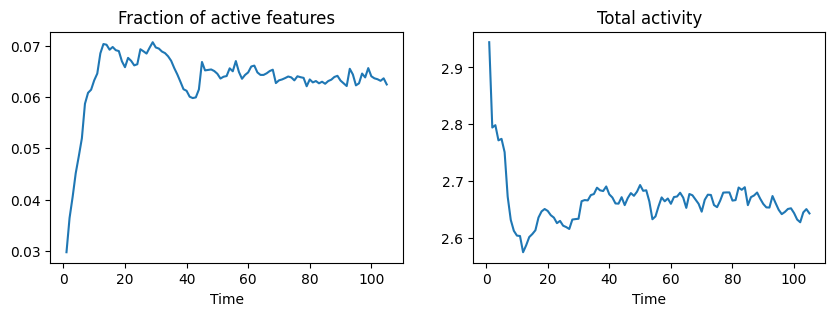

In [5]:
# Load the trajectory
trajectory_id = 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}_*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

data_chunk = get_data_chunk(trajectory, steps, act_files)

print(data_chunk.features.shape)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sort_me = np.argsort(data_chunk.t)
axs[0].plot(data_chunk.t[sort_me], np.mean(data_chunk.features > 0, axis=1)[sort_me])
axs[0].set_title(f"Fraction of active features"); axs[0].set_xlabel("Time")
axs[1].plot(data_chunk.t[sort_me], np.sum(data_chunk.features, axis=1)[sort_me])
axs[1].set_title(f"Total activity"); axs[1].set_xlabel("Time")
# axs[1].set_title('Enstrophy')
plt.show()


In [6]:
@dataclass
class EnstrophyFeatures:
    index: int
    corr: float
    pval: float

    def __lt__(self, other):
        return self.corr < other.corr

@dataclass
class EnstrophyDerivativeFeatures:
    index: int
    corr: float
    pval: float

    def __lt__(self, other):
        return self.corr < other.corr

feature_list = SortedList()
null_feature_list = SortedList()
feature_list_dEdt = SortedList()
null_feature_list_dEdt = SortedList()
num_null_samples = 100 # 100
# feature_list_dEdt = SortedList()
for feature_idx in alive_it(range(data_chunk.features.shape[1]), force_tty=True):
    enstrophy_copy = data_chunk.enstrophy.copy()

    # E
    s,p = stats.spearmanr(data_chunk.features[:, feature_idx], data_chunk.enstrophy)
    if np.isfinite(s):
        feature_list.add(EnstrophyFeatures(feature_idx, s, p))

    s_max = -np.inf; p_max = 0
    for i in range(num_null_samples):
        np.random.shuffle(enstrophy_copy)
        s,p = stats.spearmanr(data_chunk.features[:, feature_idx], enstrophy_copy)
        if np.isfinite(s) and (s > s_max):
            s_max = s
            p_max  = p
    null_feature_list.add(EnstrophyFeatures(feature_idx, s_max, p_max))

    # dEdt
    s,p = stats.spearmanr(data_chunk.dEdt, data_chunk.features[:, feature_idx])
    if np.isfinite(s):
        feature_list_dEdt.add(EnstrophyDerivativeFeatures(feature_idx, s, p))
        
    s_max = -np.inf
    for i in range(num_null_samples):
        np.random.shuffle(enstrophy_copy)
        s,p = stats.spearmanr(data_chunk.dEdt, enstrophy_copy)
        if np.isfinite(s) and (s > s_max):
                s_max = s
                p_max  = p

    null_feature_list_dEdt.add(EnstrophyDerivativeFeatures(feature_idx, s_max, p_max))

thresh = np.quantile([f.corr for f in null_feature_list], 0.99)

on 0: /tmp/ipykernel_1268309/2728209145.py:29: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
        s,p = stats.spearmanr(data_chunk.features[:, feature_idx], data_chunk.enstrophy)
      /tmp/ipykernel_1268309/2728209145.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
        s,p = stats.spearmanr(data_chunk.features[:, feature_idx], enstrophy_copy)
      /tmp/ipykernel_1268309/2728209145.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
        s,p = stats.spearmanr(data_chunk.dEdt, data_chunk.features[:, feature_idx])


|                                        | ▂▄▆ 0/22528 [0%] in 0s (~0s, 0.0/s) 

|████████████████████████████████████████| 22528/22528 [100%] in 14:26.1 (26.01/


In [7]:
output_dir = Path("figures/preprint/data")
os.makedirs(output_dir, exist_ok=True)
with open(output_dir / f"enstrophy_feature_list_traj_{trajectory_id}.pkl", "wb") as f:
    pickle.dump({'feature_ids': [feature.index for feature in feature_list[::-1]], 'significance_threshold': thresh, 'note': 'sorted in descenting order of rho'}, f)  # sorted in descending order

## Rho distribution figure

In [82]:
E_corr = np.array([feature.corr for feature in feature_list])
dEdt_corr = np.array([feature.corr for feature in feature_list_dEdt])
null_E_corr = np.array([feature.corr for feature in null_feature_list])
null_dEdt_corr = np.array([feature.corr for feature in null_feature_list_dEdt])
E_dEdt_corr = np.array([[f1.corr, f2.corr] for f1 in feature_list for f2 in feature_list_dEdt if f1.index == f2.index])

In [85]:
# print(f"Number of time steps: {data_chunk.t.shape[0]}, number of unique time steps: {len(np.unique(data_chunk.t))}")
print(f"Largest E Correlation: {feature_list[-1].corr}, p-value: {feature_list[-1].pval}")
print(f"Largest Null E Correlation: {null_feature_list[-1].corr}, p-value: {null_feature_list[-1].pval}")
threshold = np.quantile(null_E_corr, 0.99)
print(f"99-th percentile of null E Correlation: {threshold}")
print(f"Number of features with correlation > null_E_corr: {np.sum(E_corr > threshold)} / {len(E_corr)} ({np.sum(E_corr > threshold) / len(E_corr) * 100:.2f}%)")

print(f"Largest dEdt Correlation: {feature_list_dEdt[-1].corr}, p-value: {feature_list_dEdt[-1].pval}")
print(f"Largest Null dEdt Correlation: {null_feature_list_dEdt[-1].corr}, p-value: {null_feature_list_dEdt[-1].pval}")
threshold = np.quantile(null_dEdt_corr, 0.99)
print(f"99-th percentile of null dEdt Correlation: {threshold}")
print(f"Number of features with correlation > null_dEdt_corr: {np.sum(dEdt_corr > threshold)} / {len(dEdt_corr)} ({np.sum(dEdt_corr > threshold) / len(dEdt_corr) * 100:.2f}%)")



Largest E Correlation: 0.8554737715115074, p-value: 3.337601440119036e-31

Largest Null E Correlation: 0.4264552678679878, p-value: 5.729749335076082e-06

99-th percentile of null E Correlation: 0.30009768724426095

Number of features with correlation > null_E_corr: 698 / 6664 (10.47%)

Largest dEdt Correlation: 0.4993117621014599, p-value: 5.8961733562717755e-08

Largest Null dEdt Correlation: 0.4762699564586357, p-value: 2.8155659980025903e-07

99-th percentile of null dEdt Correlation: 0.3551938627410326

Number of features with correlation > null_dEdt_corr: 19 / 6664 (0.29%)

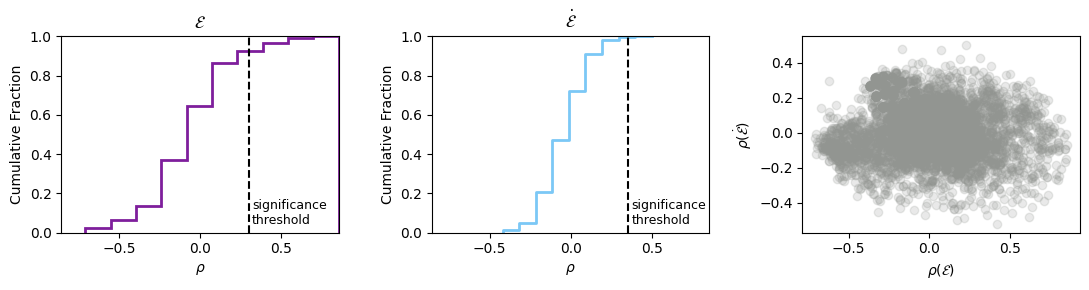

Bad pipe message: %s [b'\x18\x92;t;\x9c\xf4\xc8\x19\xe6\x90L\xe4\tB.\xc5H\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:']
Bad pipe message: %s [b'\x8a\xd1\xa0Y\xc8\x93\xefb)\xe4\xcf\xe5\xa9Y\x1dOE\xa8\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\

In [102]:

## RHO DISTRIBUTION FIGURE

# fig, axs = plt.subplots(1,1,figsize=(4.5,3))# , dpi=300)
# axs.hist(E_corr, cumulative=True, density=True, histtype='step', lw=2)
# rho_null = np.quantile(null_E_corr, 0.99) # 0.30
# axs.axvline(rho_null, color='k', linestyle='--')
# axs.text(rho_null-0.03, 0.03, 'significance\nthreshold', ha='right', va='bottom')
# axs.set_ylim(0, 1)
# axs.set_xlim(-np.max(np.abs(E_corr)), np.max(np.abs(E_corr)))
# axs.set_xlabel(r"$\rho$")
# axs.set_ylabel('Cumulative Fraction')
# fig.tight_layout()

fig, axs = plt.subplots(1,3,figsize=(11,3))# , dpi=300)

ax = axs[0]
ax.hist(E_corr, cumulative=True, density=True, histtype='step', lw=2, color='xkcd:purple')
rho_null = np.quantile(null_E_corr, 0.99) # 0.30
ax.axvline(rho_null, color='k', linestyle='--')
ax.text(rho_null+0.02, 0.03, 'significance\nthreshold', ha='left', va='bottom', fontsize=9)
ax.set_ylim(0, 1)
ax.set_xlim(-np.max(np.abs(E_corr)), np.max(np.abs(E_corr)))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel('Cumulative Fraction')
ax.set_title(r'$\mathcal{E}$')

ax = axs[1]
h,b = np.histogram(dEdt_corr, density=True)
# h = np.cumsum(h)
# ax.hist(dEdt_corr, cumulative=True, density=True, histtype='step', lw=2, color='xkcd:lightblue')
ax.step(b[1:], np.cumsum(h)*np.diff(b)[0], lw=2, color='xkcd:lightblue')
rho_null = np.quantile(null_dEdt_corr, 0.99) # 0.30
ax.axvline(rho_null, color='k', linestyle='--')
ax.text(rho_null+0.02, 0.03, 'significance\nthreshold', ha='left', va='bottom', fontsize=9)
ax.set_ylim(0, 1)
ax.set_xlim(-np.max(np.abs(E_corr)), np.max(np.abs(E_corr)))
ax.set_xlabel(r"$\rho$")
ax.set_ylabel('Cumulative Fraction')
ax.set_title(r'$\dot{{\mathcal{{E}}}}$')


ax = axs[2]
ax.scatter(E_dEdt_corr[:,0], E_dEdt_corr[:,1], alpha=0.2, color='xkcd:gray')
ax.set_xlabel(r"$\rho(\mathcal{E})$")
ax.set_ylabel(r"$\rho(\dot{\mathcal{E}})$")
plt.subplots_adjust(wspace=0.28)
fig.tight_layout()
plt.savefig("figures/preprint/rho_distribution.png", dpi=300)

# fig, axs = plt.subplots(1, 2, figsize=(10, 3))#, dpi=300)
# axs[0].plot(E_corr, '-x', label='E')
# axs[0].axhline(null_E_corr.max(), color='k', linestyle='--')
# axs[1].hist(E_corr, bins=100)
# axs[0].set_ylabel('Correlation')
# axs[1].set_ylabel('Count')
# axs[0].legend()
# plt.show()



feature_list[-1].index: 11253, corr: 0.8554737715115074

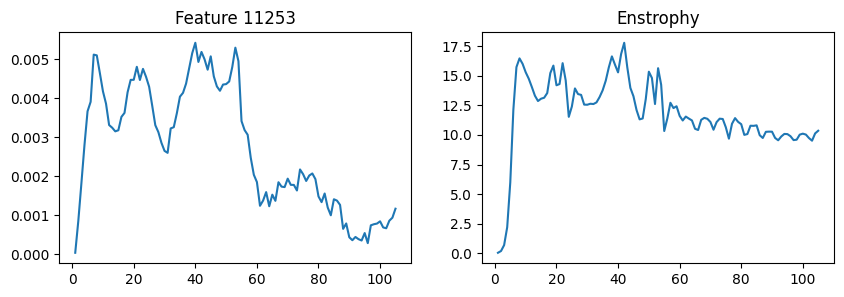

In [8]:
feature_index = -1
print(f"feature_list[-1].index: {feature_list[feature_index].index}, corr: {feature_list[feature_index].corr}")
sort_me = np.argsort(data_chunk.t)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(data_chunk.t[sort_me], data_chunk.features[:, feature_list[feature_index].index][sort_me])
axs[0].set_title(f"Feature {feature_list[-1].index}")
axs[1].plot(data_chunk.t[sort_me], data_chunk.enstrophy[sort_me])
axs[1].set_title('Enstrophy')
plt.show()

output_dir = Path("figures/preprint/data")
os.makedirs(output_dir, exist_ok=True)
with open(output_dir / f"enstrophy_feature_{feature_list[-1].index}.pkl", "wb") as f:
    pickle.dump({'t': data_chunk.t, 'enstrophy': data_chunk.enstrophy[sort_me], 'features':data_chunk.features[:, feature_list[feature_index].index][sort_me]}, f)

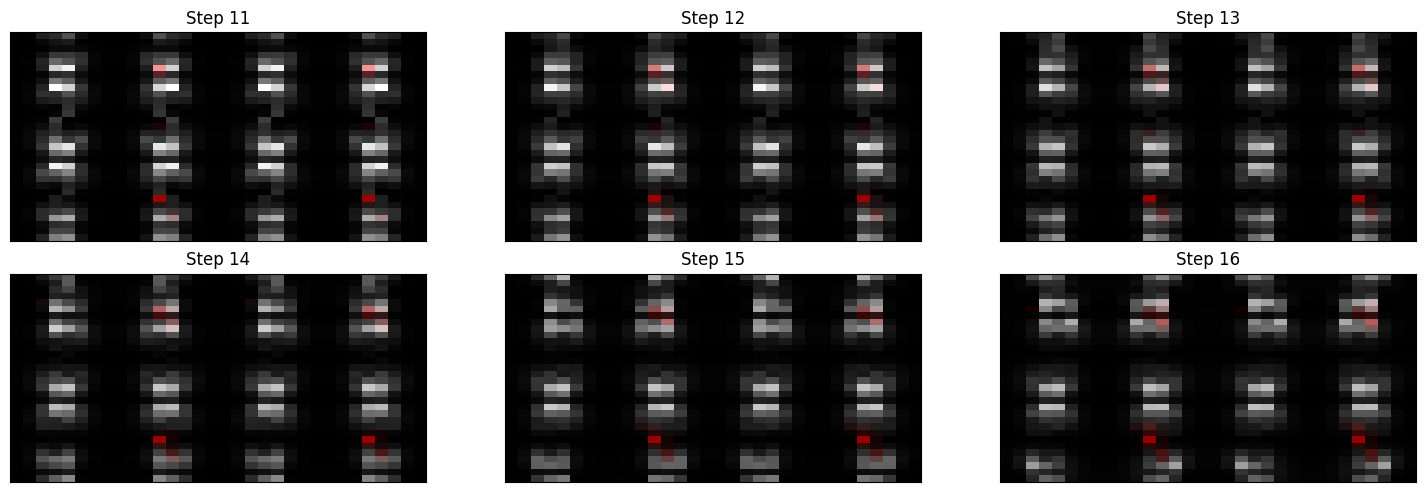

In [17]:
target_step = 10
feature_index = -1
step_index = np.argmin(np.abs(steps - target_step))
step = steps[step_index]
cmap = LinearSegmentedColormap.from_list('mask', [(1, 0, 0, 0), (1, 0, 0, 0.6)])

simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
scale_x = int(simulation_chunk.shape[2] / 32)  # width
scale_y = int(simulation_chunk.shape[1] / 32)  # height

act = zarr.open(act_files[step_index], mode="r")
act = torch.from_numpy(np.array(act)).to(device)
with torch.no_grad():
    _, code, _ = sae_model(act)
code = code.cpu().numpy().reshape(6, 32, 32, -1)

enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32))
for i in range(simulation_chunk.shape[0]):
    for ix in range(32):
        for iy in range(32):
            token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
            enstrophy[i, iy, ix] = metrics.compute_enstrophy(token[:, :, 2], token[:, :, 3])[0]
dEdt = -1*np.diff(enstrophy, axis=0)

extent = (0.5, 512.5, 256.5, 0.5)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
vmin = np.min(enstrophy[:-1])
vmax = np.max(enstrophy[:-1])
for i in range(dEdt.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(enstrophy[i], extent=extent, cmap='gray', vmin=vmin, vmax=vmax)
    ax.imshow(code[i, ..., feature_list[feature_index].index], extent=extent, cmap=cmap, vmin=0, vmax=code[i, ..., feature_list[feature_index].index].max())
    ax.set_title(f"Step {step + i}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()



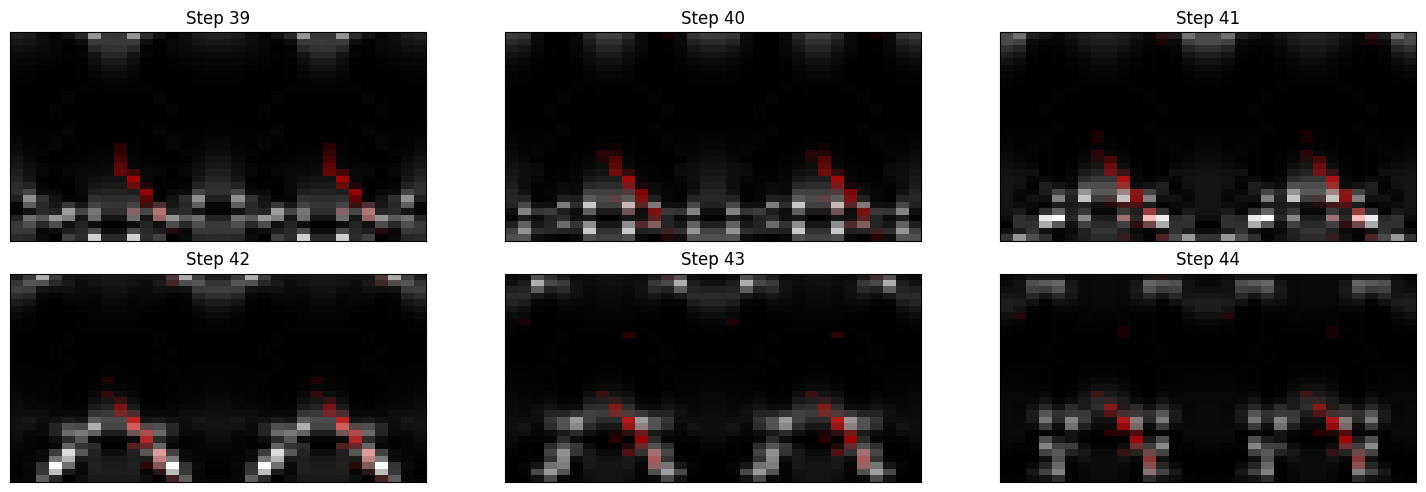

In [18]:
target_step = 40
feature_index = -1
step_index = np.argmin(np.abs(steps - target_step))
step = steps[step_index]
cmap = LinearSegmentedColormap.from_list('mask', [(1, 0, 0, 0), (1, 0, 0, 0.6)])

simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
scale_x = int(simulation_chunk.shape[2] / 32)  # width
scale_y = int(simulation_chunk.shape[1] / 32)  # height

act = zarr.open(act_files[step_index], mode="r")
act = torch.from_numpy(np.array(act)).to(device)
with torch.no_grad():
    _, code, _ = sae_model(act)
code = code.cpu().numpy().reshape(6, 32, 32, -1)

enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32))
for i in range(simulation_chunk.shape[0]):
    for ix in range(32):
        for iy in range(32):
            token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
            enstrophy[i, iy, ix] = metrics.compute_enstrophy(token[:, :, 2], token[:, :, 3])[0]
dEdt = -1*np.diff(enstrophy, axis=0)

extent = (0.5, 512.5, 256.5, 0.5)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
vmin = np.min(enstrophy[:-1])
vmax = np.max(enstrophy[:-1])
for i in range(dEdt.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(enstrophy[i], extent=extent, cmap='gray', vmin=vmin, vmax=vmax)
    ax.imshow(code[i, ..., feature_list[feature_index].index], extent=extent, cmap=cmap, vmin=0, vmax=code[i, ..., feature_list[feature_index].index].max())
    ax.set_title(f"Step {step + i}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()



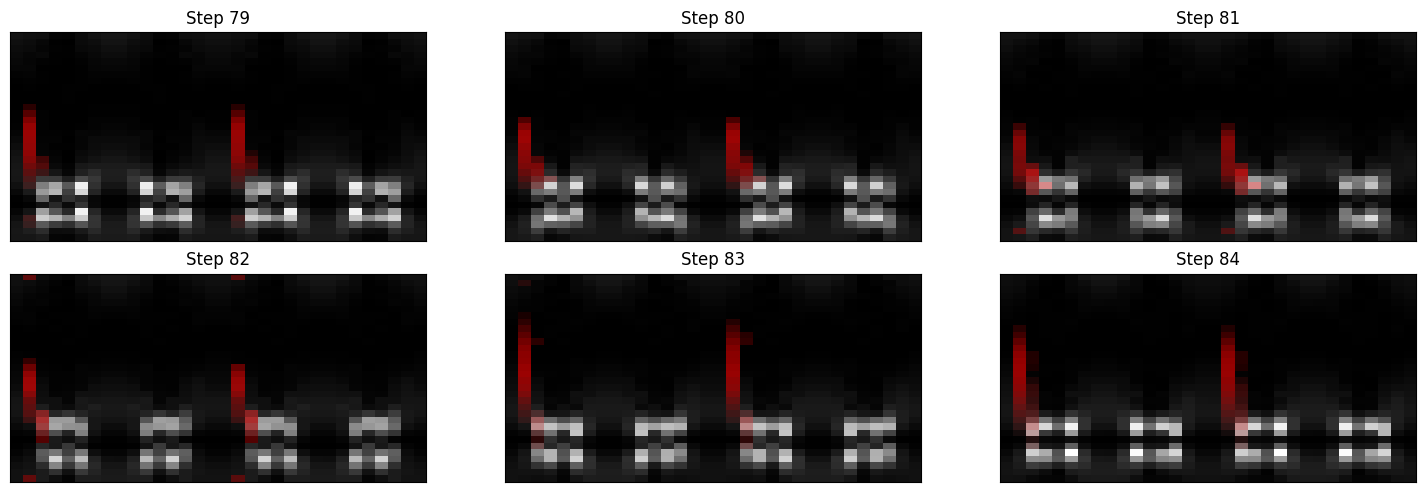

In [11]:
target_step = 80
feature_index = -2
step_index = np.argmin(np.abs(steps - target_step))
step = steps[step_index]
cmap = LinearSegmentedColormap.from_list('mask', [(1, 0, 0, 0), (1, 0, 0, 0.6)])

simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
scale_x = int(simulation_chunk.shape[2] / 32)  # width
scale_y = int(simulation_chunk.shape[1] / 32)  # height

act = zarr.open(act_files[step_index], mode="r")
act = torch.from_numpy(np.array(act)).to(device)
with torch.no_grad():
    _, code, _ = sae_model(act)
code = code.cpu().numpy().reshape(6, 32, 32, -1)

enstrophy = np.zeros((simulation_chunk.shape[0], 32, 32))
for i in range(simulation_chunk.shape[0]):
    for ix in range(32):
        for iy in range(32):
            token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
            enstrophy[i, iy, ix] = metrics.compute_enstrophy(token[:, :, 2], token[:, :, 3])[0]
dEdt = -1*np.diff(enstrophy, axis=0)

extent = (0.5, 512.5, 256.5, 0.5)
fig, axs = plt.subplots(2, 3, figsize=(15, 5))
vmin = np.min(enstrophy[:-1])
vmax = np.max(enstrophy[:-1])
for i in range(dEdt.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(enstrophy[i], extent=extent, cmap='gray', vmin=vmin, vmax=vmax)
    ax.imshow(code[i, ..., feature_list[feature_index].index], extent=extent, cmap=cmap, vmin=0, vmax=code[i, ..., feature_list[feature_index].index].max())
    ax.set_title(f"Step {step + i}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()



feature_list[-1].index: 178, corr: 0.4955592326775383

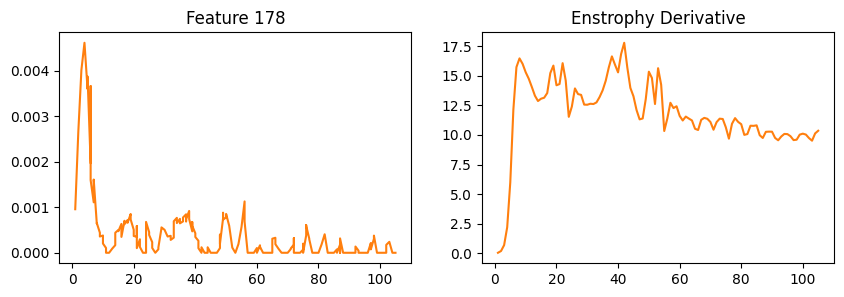

In [8]:
print(f"feature_list[-1].index: {feature_list_dEdt[-1].index}, corr: {feature_list_dEdt[-1].corr}")
sort_me = np.argsort(data_chunk.t)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(data_chunk.t[sort_me], data_chunk.features[:, feature_list_dEdt[-1].index][sort_me], color='C1')
axs[0].set_title(f"Feature {feature_list_dEdt[-1].index}")
axs[1].plot(data_chunk.t[sort_me], data_chunk.enstrophy[sort_me], color='C1')
axs[1].set_title('Enstrophy Derivative')
plt.show()

In [9]:
# Load the trajectory
trajectory_id = 56
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}_*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

data_chunk_56 = get_data_chunk(trajectory, steps, act_files)

|████████████████████████████████████████| 34/34 [100%] in 17.6s (1.91/s)       


feature_list[-1].index: 9030, s: 0.5145351262297959, p: 3.4812863993295085e-15

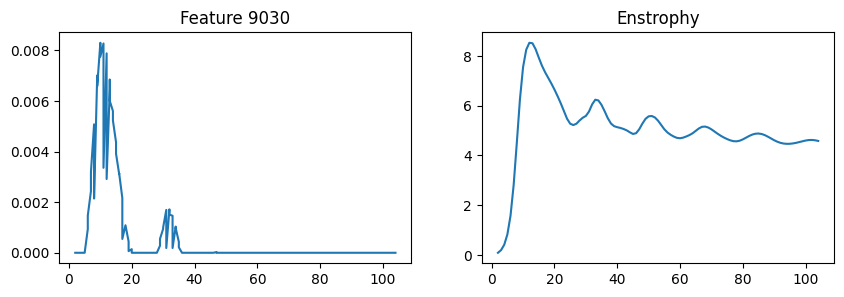

In [10]:
s,p = stats.spearmanr(data_chunk_56.features[:, feature_list[-1].index], data_chunk_56.enstrophy)
print(f"feature_list[-1].index: {feature_list[-1].index}, s: {s}, p: {p}")
sort_me = np.argsort(data_chunk_56.t)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(data_chunk_56.t[sort_me], data_chunk_56.features[:, feature_list[-1].index][sort_me])
axs[0].set_title(f"Feature {feature_list[-1].index}")
axs[1].plot(data_chunk_56.t[sort_me], data_chunk_56.enstrophy[sort_me])
axs[1].set_title('Enstrophy')
plt.show()

feature_list[-1].index: 178, s: 0.4353767599291501, p: 7.627454523432156e-11

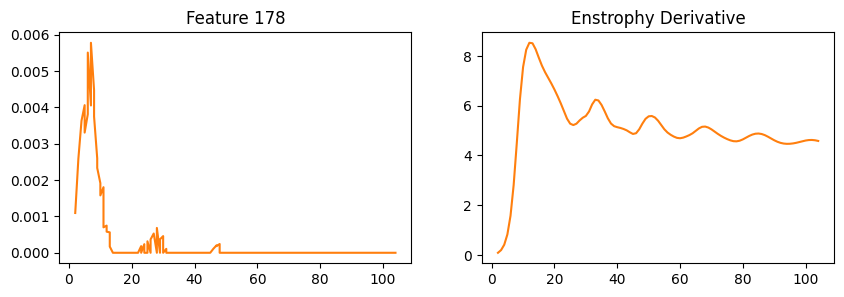

In [11]:
s,p = stats.spearmanr(data_chunk_56.features[:, feature_list_dEdt[-1].index], data_chunk_56.dEdt)
sort_me = np.argsort(data_chunk_56.t)
print(f"feature_list[-1].index: {feature_list_dEdt[-1].index}, s: {s}, p: {p}")
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(data_chunk_56.t[sort_me], data_chunk_56.features[:, feature_list_dEdt[-1].index][sort_me], color='C1')
axs[0].set_title(f"Feature {feature_list_dEdt[-1].index}")
axs[1].plot(data_chunk_56.t[sort_me], data_chunk_56.enstrophy[sort_me], color='C1')
axs[1].set_title('Enstrophy Derivative')
plt.show()

|████████████████████████████████████████| 34/34 [100%] in 17.9s (1.88/s)       


/tmp/ipykernel_2411613/3979356916.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s,p = stats.spearmanr(data_chunk_3.features[:, feature_list[-1].index], data_chunk_3.enstrophy)


feature_list[-1].index: 9030, s: nan, p: nan

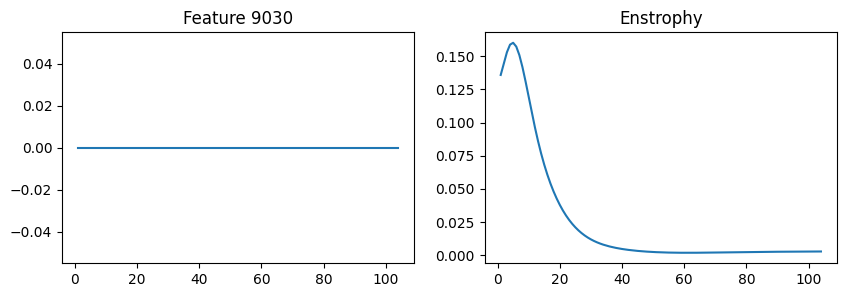

feature_list[-1].index: 178, s: 0.05112078576091764, p: 0.46775344200712393

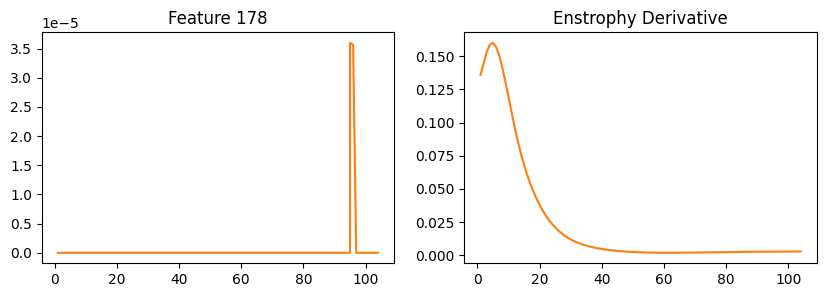

In [13]:
# Load the trajectory
trajectory_id = 3
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}_*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

data_chunk_3 = get_data_chunk(trajectory, steps, act_files)

s,p = stats.spearmanr(data_chunk_3.features[:, feature_list[-1].index], data_chunk_3.enstrophy)
print(f"feature_list[-1].index: {feature_list[-1].index}, s: {s}, p: {p}")
sort_me = np.argsort(data_chunk_3.t)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(data_chunk_3.t[sort_me], data_chunk_3.features[:, feature_list[-1].index][sort_me])
axs[0].set_title(f"Feature {feature_list[-1].index}")
axs[1].plot(data_chunk_3.t[sort_me], data_chunk_3.enstrophy[sort_me])
axs[1].set_title('Enstrophy')
plt.show()

s,p = stats.spearmanr(data_chunk_3.features[:, feature_list_dEdt[-1].index], data_chunk_3.dEdt)
sort_me = np.argsort(data_chunk_3.t)
print(f"feature_list[-1].index: {feature_list_dEdt[-1].index}, s: {s}, p: {p}")
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(data_chunk_3.t[sort_me], data_chunk_3.features[:, feature_list_dEdt[-1].index][sort_me], color='C1')
axs[0].set_title(f"Feature {feature_list_dEdt[-1].index}")
axs[1].plot(data_chunk_3.t[sort_me], data_chunk_3.enstrophy[sort_me], color='C1')
axs[1].set_title('Enstrophy Derivative')
plt.show()

## Inspect targets

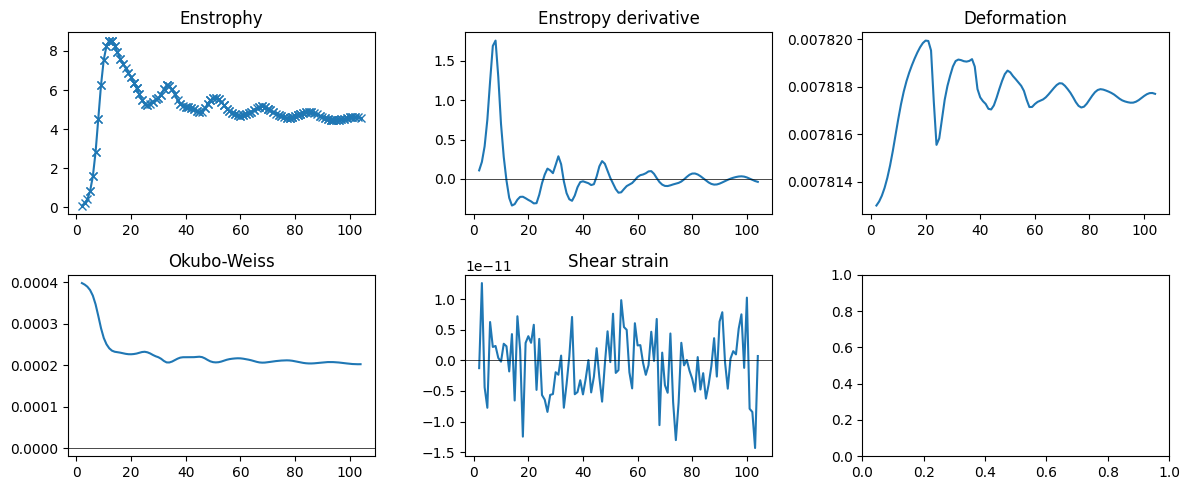

In [43]:

# Load the trajectory
trajectory_id = 56
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

plot_metrics(trajectory, steps)


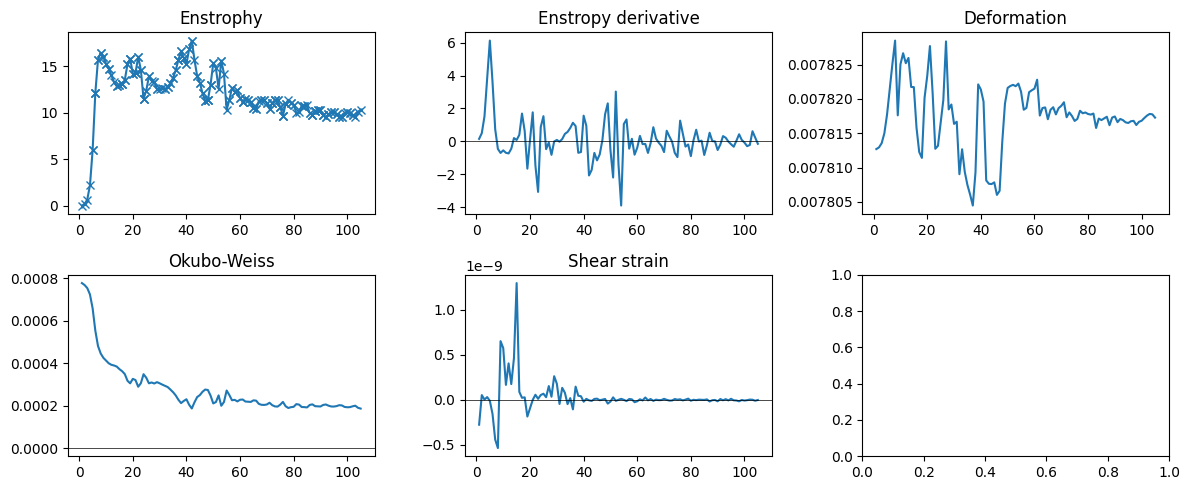

In [44]:

# Load the trajectory
trajectory_id = 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

plot_metrics(trajectory, steps)


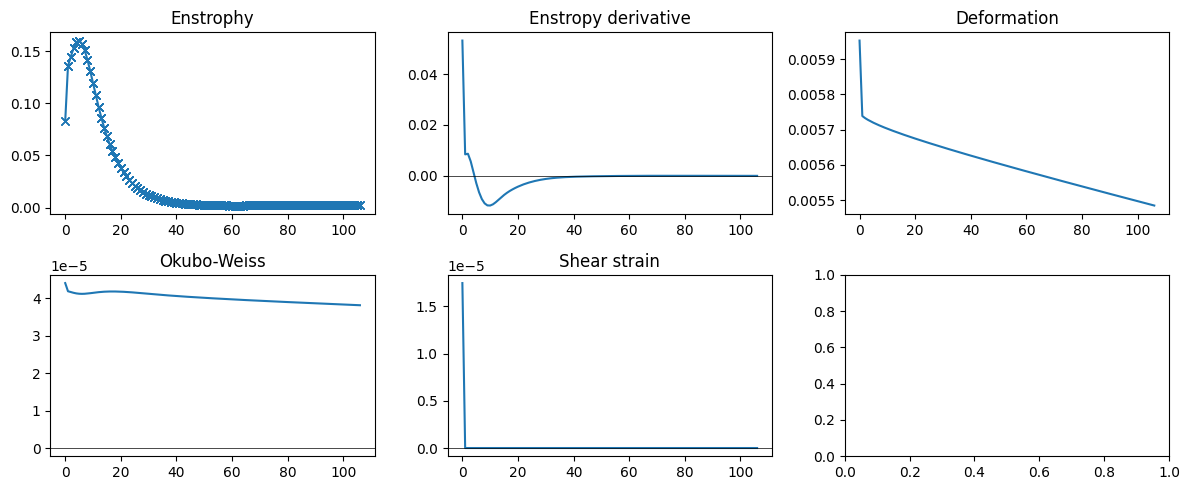

In [45]:

# Load the trajectory
trajectory_id = 3
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

plot_metrics(trajectory, steps)
